This command installs the prophet package — a forecasting tool developed by Facebook (now Meta), used for time series forecasting

In [19]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet  # Use 'prophet' instead of 'fbprophet'

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    '''Calculates MAPE given y_true and y_pred'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
file_path = r'C:\Users\Wsiwale\Desktop\Dataset\Hourly-Energy-Consumpution\PJME_hourly.csv'

df = pd.read_csv(file_path, index_col=0, parse_dates=[0])

In [22]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


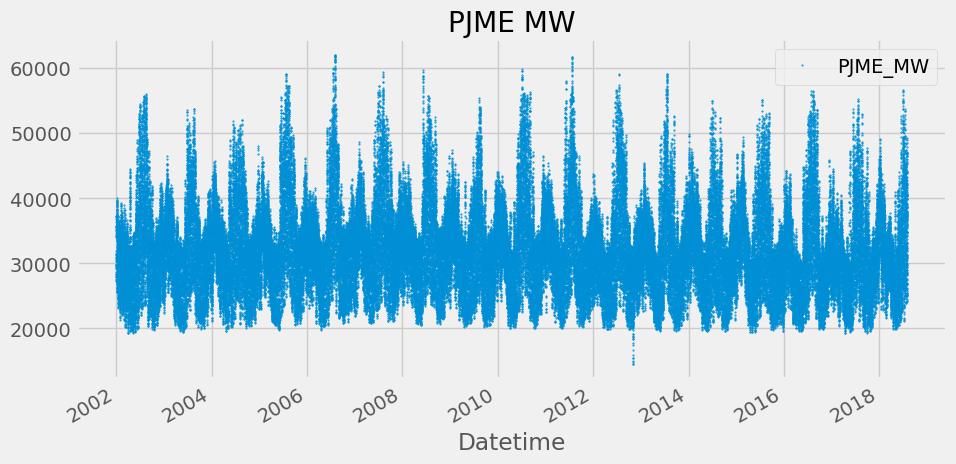

In [23]:
color_pal = sns.color_palette()
df.plot(style='.',
figsize=(10,  5),
       ms=1,
       color=color_pal[0],
       title='PJME MW')
plt.show()

Now Let make some Time Series Features

In [24]:
# Import CategoricalDtype to define an ordered categorical variable (e.g., for weekdays)
from pandas.api.types import CategoricalDtype
# Import the pandas library for data manipulation
import pandas as pd

# Define a custom categorical type for weekdays in a specific (ordered) sequence
cat_type = CategoricalDtype(categories=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday', 'Sunday'
], ordered=True)

# Define a function to extract and create time-based features from a DataFrame
def create_features(df, label=None):
    '''
    Create time series features from datetime index.
    '''
    # Create a copy of the input DataFrame to avoid modifying the original
    df = df.copy()

    # Create a new column 'date' from the index assuming it's a datetime index
    df['date'] = df.index

    # Extract the hour of the day from the datetime
    df['hour'] = df['date'].dt.hour

    # Extract the day of the week as an integer (0=Monday, 6=Sunday)
    df['dayofweek'] = df['date'].dt.dayofweek

    # Extract the day name (e.g., 'Monday', 'Tuesday') from the datetime
    df['weekday'] = df['date'].dt.day_name()

    # Convert 'weekday' to an ordered categorical type using the defined `cat_type`
    df['weekday'] = df['weekday'].astype(cat_type)

    # Extract the quarter of the year (1 to 4)
    df['quarter'] = df['date'].dt.quarter

    # Extract the month (1 to 12)
    df['month'] = df['date'].dt.month

    # Extract the year (e.g., 2020, 2021)
    df['year'] = df['date'].dt.year

    # Extract the day of the year (1 to 365 or 366)
    df['dayofyear'] = df['date'].dt.dayofyear

    # Extract the day of the month (1 to 31)
    df['dayofmonth'] = df['date'].dt.day

    # Extract the ISO week number of the year
    df['weekofyear'] = df['date'].dt.isocalendar().week

    # Create a numeric "date offset" to help map dates to seasons
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    # Categorize the 'date_offset' into one of the four seasons using bin ranges
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    # Select relevant feature columns to return as the feature set (X)
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]

    # If a label/target column is specified, return features X and target y
    if label:
        y = df[label]
        return X, y
    else:
        # Otherwise, return only the feature set X
        return X

# Example usage of the function:
# Generate features and target from DataFrame `df` using 'PJME_MW' as the target variable
X, y = create_features(df, label='PJME_MW')

# Combine features and target into a single DataFrame for analysis or modeling
features_and_target = pd.concat([X, y], axis=1)

In [25]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


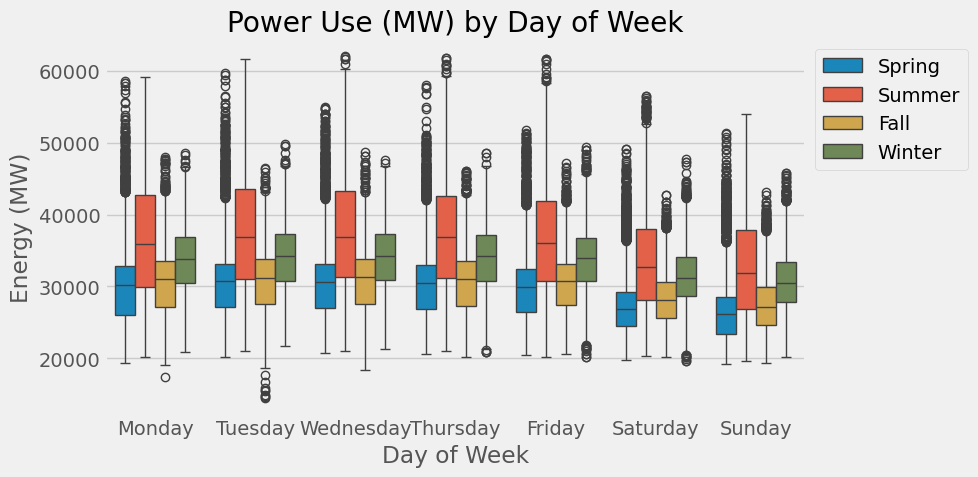

In [26]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Create a boxplot of PJME_MW by weekday and season
sns.boxplot(
    data=features_and_target.dropna(),  # Ensure no missing values
    x='weekday',
    y='PJME_MW',
    hue='season',
    ax=ax,
    linewidth=1                        
)

# Set title and axis labels
ax.set_title('Power Use (MW) by Day of Week')  # Fixed title wording
ax.set_xlabel('Day of Week')                   # Fixed from set_alabel → set_xlabel
ax.set_ylabel('Energy (MW)')

# Move legend to top-right outside the plot
ax.legend(bbox_to_anchor=(1, 1))

# Make layout tight and show plot
plt.tight_layout()
plt.show()

TRAIN / TEST SPLIT

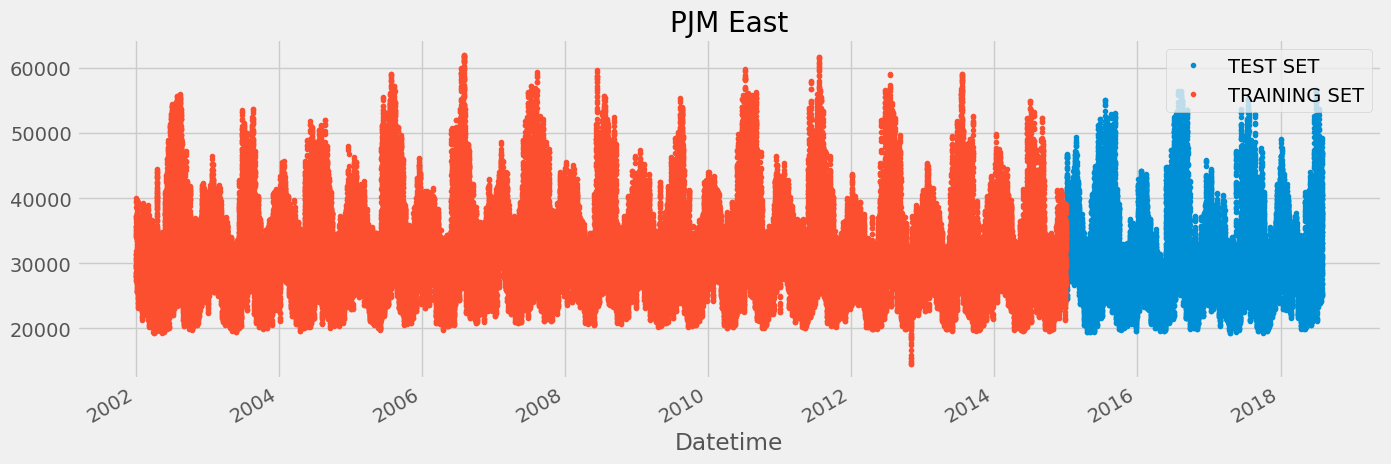

In [27]:
split_date = '1-Jan-2015'

# Train set: data before or on the split date
df_train = df.loc[df.index <= split_date].copy()

# Test set: data after the split date
df_test = df.loc[df.index > split_date].copy()

# Plot train and test sets for visual comparison
df_test.rename(columns={'PJME_MW': 'TEST SET'})\
    .join(df_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer')\
    .plot(figsize=(15, 5), title='PJM East', style='.')

plt.show()

Simple Prophet Model
 -  Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
 -  Datetime column named ds
 -  target: y

In [28]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
  .rename(columns={'Datetime': 'ds',
                   'PJME_MW' : 'y'})


In [29]:
df_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [30]:
%%time
model = Prophet()
model.fit(df_train_prophet)

21:39:56 - cmdstanpy - INFO - Chain [1] start processing
21:41:42 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 5.73 s
Wall time: 1min 53s


In [36]:
# Predict on test set with model
df_test_prophet = df_test.reset_index()\
.rename(columns ={'Datetime' : 'ds',
                  'PJME_MW': 'y'})

df_test_fost = model.predict(df_test_prophet)

In [37]:
df_test_fost.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.420813,23625.067532,32696.172272,31214.420813,31214.420813,-2835.417939,-2835.417939,-2835.417939,-4430.360197,...,1281.390107,1281.390107,1281.390107,313.552151,313.552151,313.552151,0.0,0.0,0.0,28379.002874
1,2015-01-01 02:00:00,31214.383693,22461.867807,31211.657039,31214.383693,31214.383693,-4339.789544,-4339.789544,-4339.789544,-5927.274407,...,1272.632061,1272.632061,1272.632061,314.852802,314.852802,314.852802,0.0,0.0,0.0,26874.594149
2,2015-01-01 03:00:00,31214.346573,21178.027745,30446.613077,31214.346573,31214.346573,-5211.485567,-5211.485567,-5211.485567,-6790.348748,...,1262.668237,1262.668237,1262.668237,316.194944,316.194944,316.194944,0.0,0.0,0.0,26002.861007
3,2015-01-01 04:00:00,31214.309453,21359.620154,30253.516430,31214.309453,31214.309453,-5353.038520,-5353.038520,-5353.038520,-6922.239359,...,1251.622235,1251.622235,1251.622235,317.578604,317.578604,317.578604,0.0,0.0,0.0,25861.270933
4,2015-01-01 05:00:00,31214.272334,22009.106347,30827.084087,31214.272334,31214.272334,-4678.701426,-4678.701426,-4678.701426,-6237.335097,...,1239.629865,1239.629865,1239.629865,319.003806,319.003806,319.003806,0.0,0.0,0.0,26535.570907


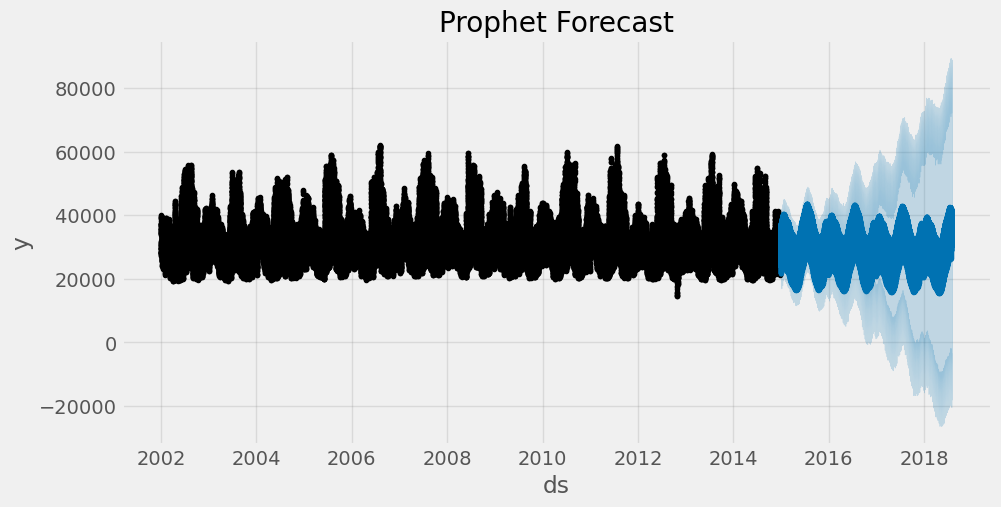

In [39]:
fig, ax =plt.subplots(figsize=(10,5))
fig = model.plot(df_test_fost, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

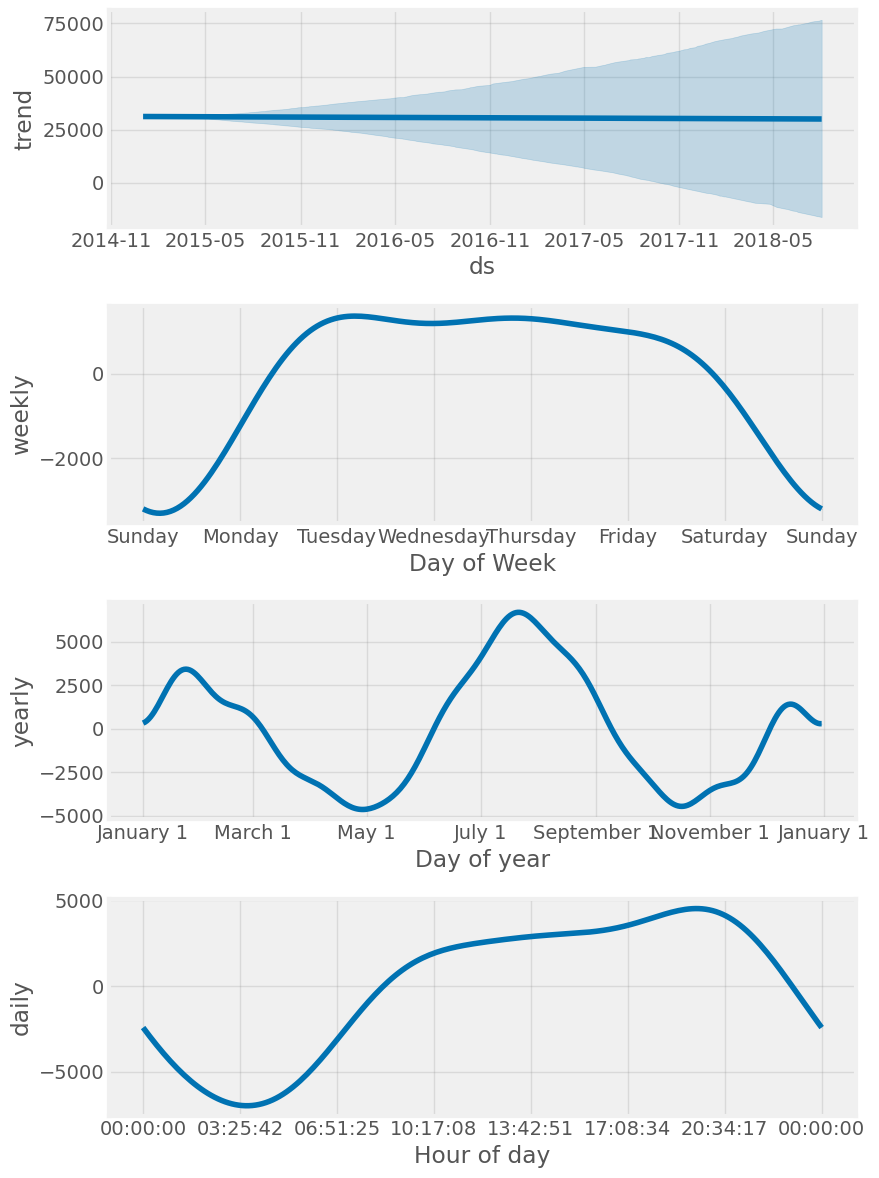

In [40]:
model.plot_components(df_test_fost)
plt.show()

Compare Forecast to Actuals

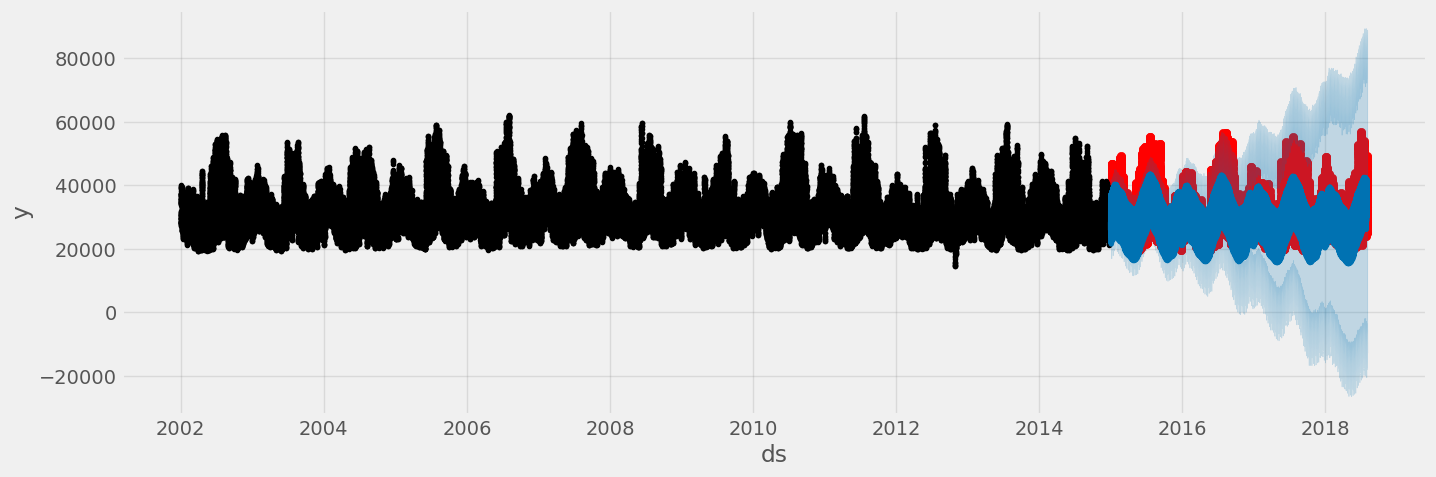

In [41]:
#PLot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fost, ax=ax)

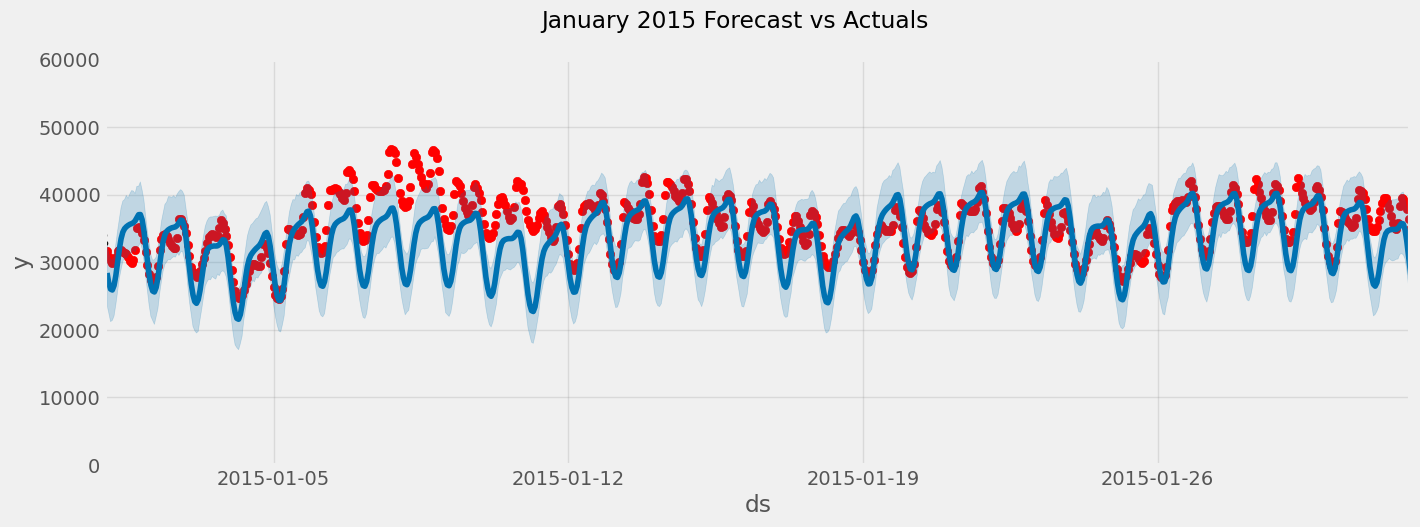

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fost, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'),
              upper=pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

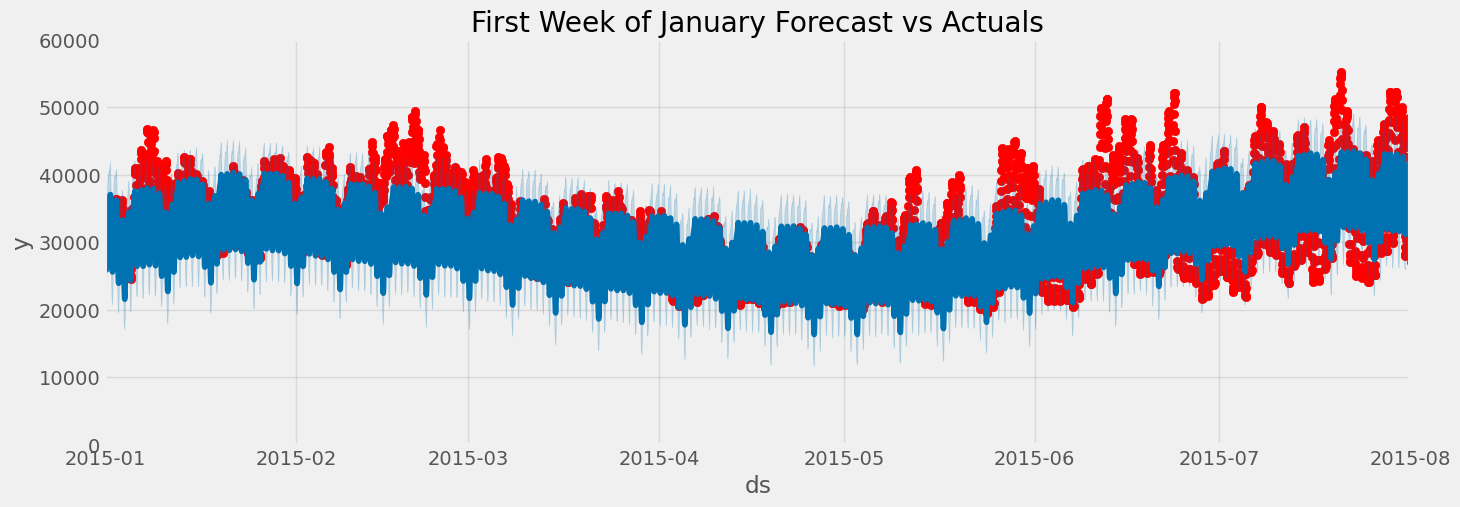

In [44]:
#Plot the Forecast with the actuals
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fost, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-01'),
              upper=pd.to_datetime('2015-08-01'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

Evalute the model with Error Metrics

In [45]:
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost['yhat']))

6614.471677632393

In [47]:
mean_absolute_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost['yhat'])

5181.449393612847

In [48]:
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost['yhat'])

16.50925333914033

Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the bulid in pandas paZedHolidayCalendar to pull the list of Holiday in Zambia Coppera pa Muf 

In [49]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import pandas as pd

class ZambiaHolidaysCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('International Womens Day', month=3, day=8),
        Holiday('Youth Day', month=3, day=12),
        Holiday('Good Friday', month=4, day=18),
        Holiday('Holy Saturday', month=4, day=19),
        Holiday('Easter Sunday', month=4, day=20),
        Holiday('Easter Monday', month=4, day=21),
        Holiday('Kenneth Kaunda Day', month=4, day=28),
        Holiday('Labour Day', month=5, day=1),
        Holiday('Africa Freedom Day', month=5, day=25),
        Holiday('Heroes Day', month=6, day=30),
        Holiday('Unity Day', month=7, day=1),
        Holiday('Farmers Day', month=8, day=4),
        Holiday('Prayer Day', month=10, day=18),
        Holiday('Independence Day', month=10, day=24),
        Holiday('Christmas Day', month=12, day=25),
        # Add more Zambian holidays as needed
    ]

# To get holiday dates:
zambia_holidays = ZambiaHolidaysCalendar().holidays(start='2010-01-01', end='2030-12-31')
print(zambia_holidays)

DatetimeIndex(['2010-01-01', '2010-03-08', '2010-03-12', '2010-04-18',
               '2010-04-19', '2010-04-20', '2010-04-21', '2010-04-28',
               '2010-05-01', '2010-05-25',
               ...
               '2030-04-21', '2030-04-28', '2030-05-01', '2030-05-25',
               '2030-06-30', '2030-07-01', '2030-08-04', '2030-10-18',
               '2030-10-24', '2030-12-25'],
              dtype='datetime64[ns]', length=336, freq=None)


In [60]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import pandas as pd

# Define your own Zambian Holiday Calendar
class ZambianHolidayCalendar(AbstractHolidayCalendar):
    rules = [
       Holiday('New Year', month=1, day=1),
        Holiday('International Womens Day', month=3, day=8),
        Holiday('Youth Day', month=3, day=12),
        Holiday('Good Friday', month=4, day=18),
        Holiday('Holy Saturday', month=4, day=19),
        Holiday('Easter Sunday', month=4, day=20),
        Holiday('Easter Monday', month=4, day=21),
        Holiday('Kenneth Kaunda Day', month=4, day=28),
        Holiday('Labour Day', month=5, day=1),
        Holiday('Africa Freedom Day', month=5, day=25),
        Holiday('Heroes Day', month=6, day=30),
        Holiday('Unity Day', month=7, day=1),
        Holiday('Farmers Day', month=8, day=4),
        Holiday('Prayer Day', month=10, day=18),
        Holiday('Independence Day', month=10, day=24),
        Holiday('Christmas Day', month=12, day=25),
        # Add more Zambian holidays as needed
    ]

# Create the calendar instance
cal = ZambianHolidayCalendar()

# Use it to get the list of holidays in the date range
holidays = cal.holidays(start=df.index.min(), end=df.index.max(),
                       return_name=True)

# Convert to DataFrame
holiday_df = pd.DataFrame(data=holidays, columns=['holiday']) 
holiday_df = holiday_df.reset_index().rename(columns={'index': 'ds'})

,ds,holiday
0,2002-03-08,International Womens Day
1,2002-03-12,Youth Day
2,2002-04-18,Good Friday
3,2002-04-19,Holy Saturday
4,2002-04-20,Easter Sunday
...,...,...
262,2018-04-28,Kenneth Kaunda Day
263,2018-05-01,Labour Day
264,2018-05-25,Africa Freedom Day
265,2018-06-30,Heroes Day


In [61]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(df_train_prophet)

23:46:17 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 6.22 s
Wall time: 2min 13s


In [66]:
#Prediction on training set with model
df_test_fost_with_hols = ( 
model_with_holidays.predict(df =df_test_prophet))

In [67]:
df_test_fost_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Africa Freedom Day,Africa Freedom Day_lower,Africa Freedom Day_upper,Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31211.887685,20911.543831,30109.671125,31211.887685,31211.887685,0.0,0.0,0.0,0.0,...,1285.260246,1285.260246,1285.260246,662.654781,662.654781,662.654781,0.0,0.0,0.0,25482.356725
1,2015-01-01 02:00:00,31211.848417,19844.959954,28734.433189,31211.848417,31211.848417,0.0,0.0,0.0,0.0,...,1276.634896,1276.634896,1276.634896,663.495147,663.495147,663.495147,0.0,0.0,0.0,23977.522717
2,2015-01-01 03:00:00,31211.809150,18857.560291,27477.287506,31211.809150,31211.809150,0.0,0.0,0.0,0.0,...,1266.795902,1266.795902,1266.795902,664.371610,664.371610,664.371610,0.0,0.0,0.0,23105.347626
3,2015-01-01 04:00:00,31211.769883,18412.319540,27594.338909,31211.769883,31211.769883,0.0,0.0,0.0,0.0,...,1255.862893,1255.862893,1255.862893,665.284214,665.284214,665.284214,0.0,0.0,0.0,22963.356203
4,2015-01-01 05:00:00,31211.730616,18992.247313,28050.761694,31211.730616,31211.730616,0.0,0.0,0.0,0.0,...,1243.967782,1243.967782,1243.967782,666.233003,666.233003,666.233003,0.0,0.0,0.0,23637.293625


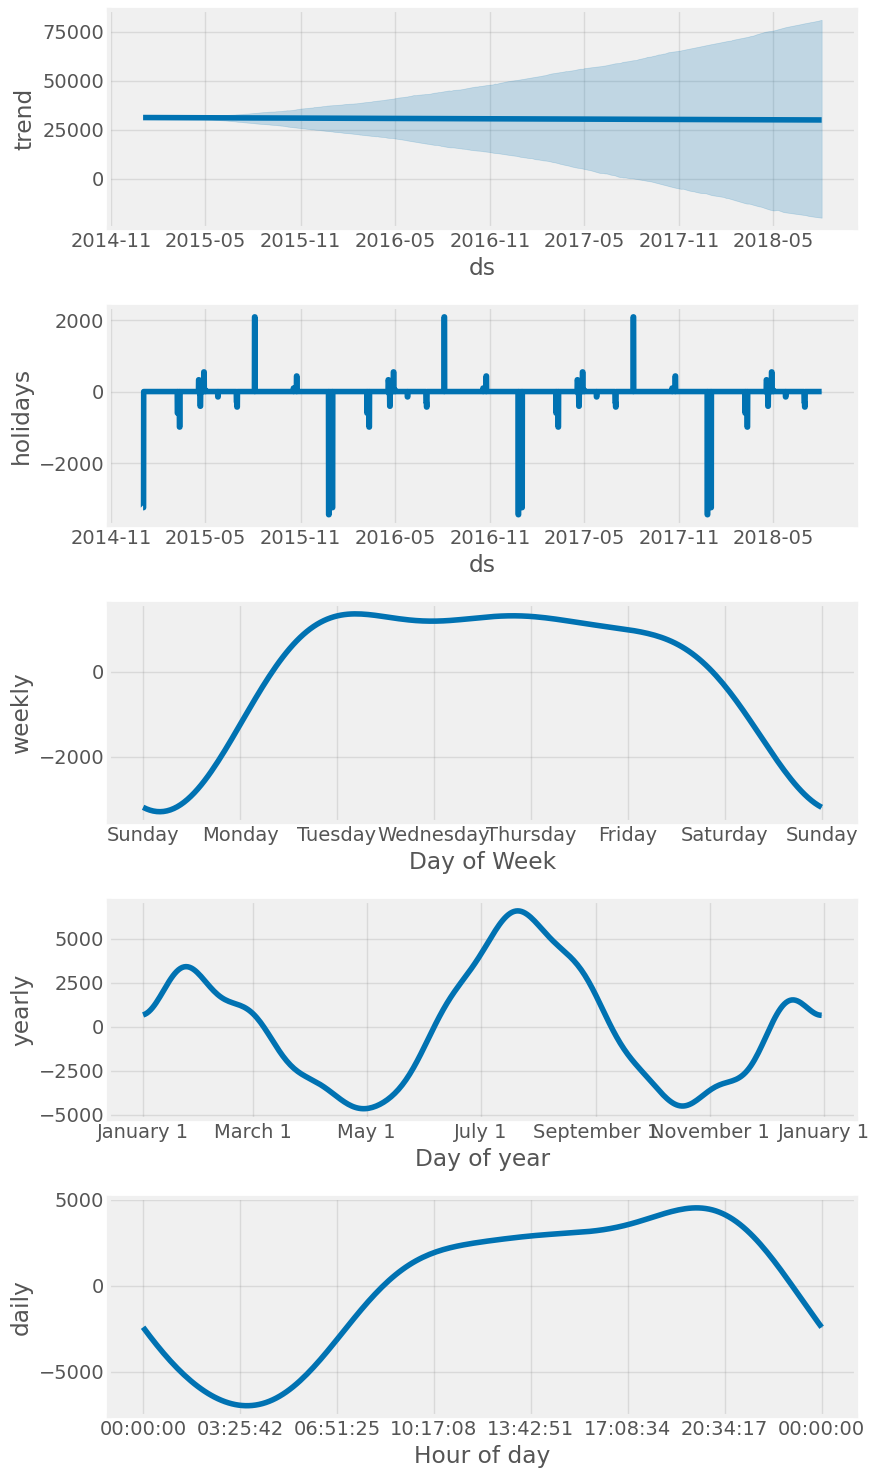

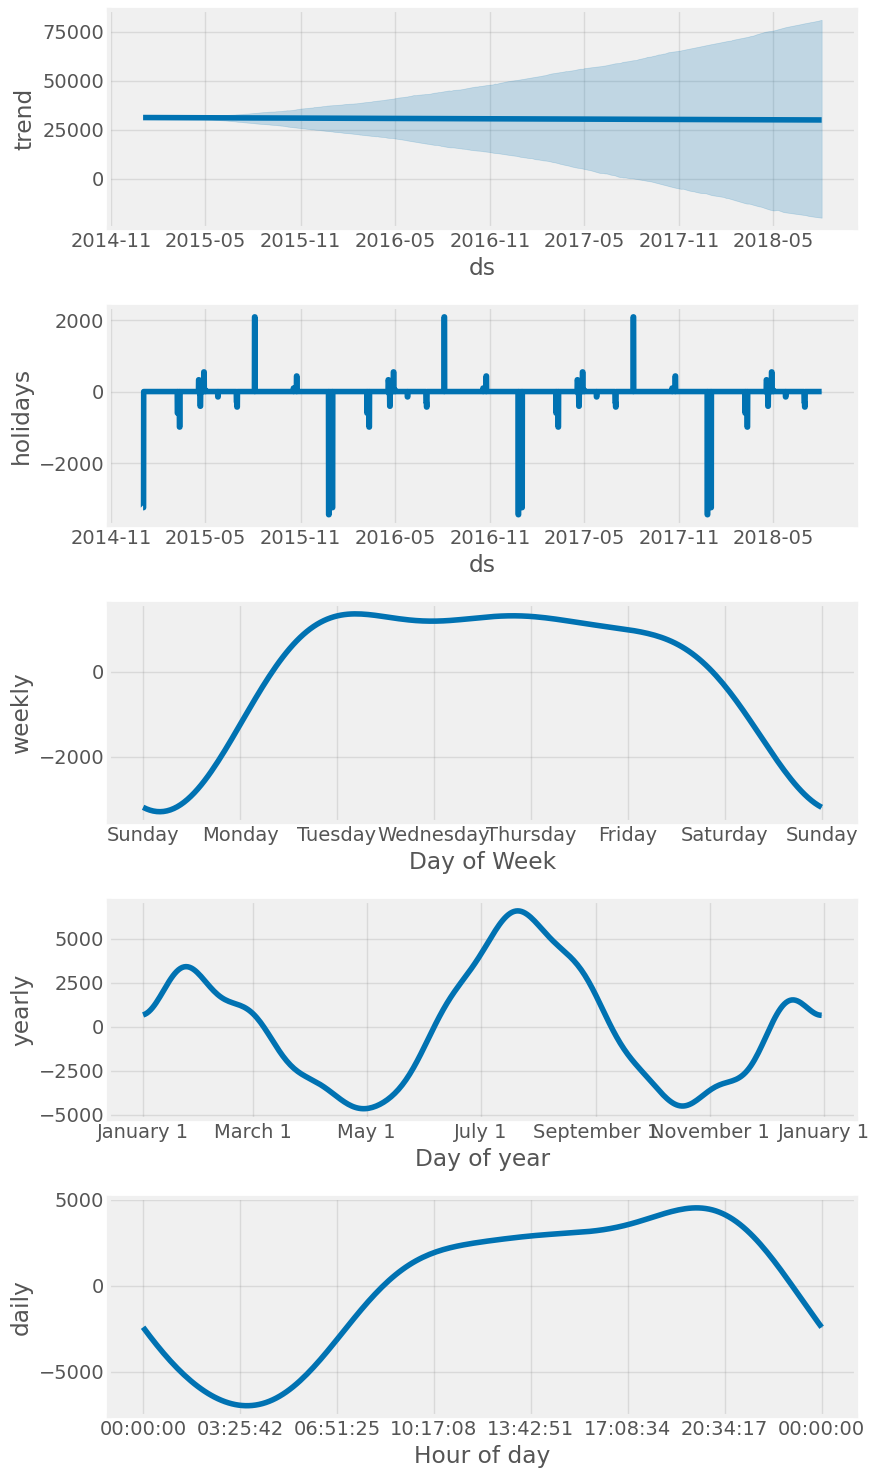

In [68]:
model_with_holidays.plot_components(
 df_test_fost_with_hols   
)

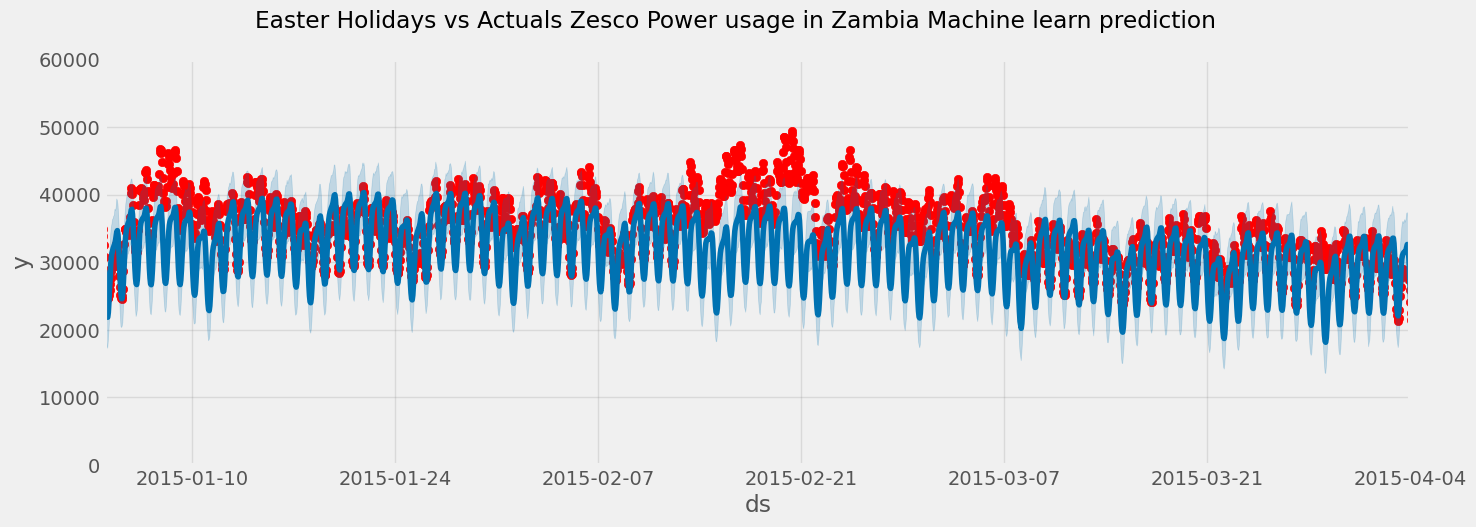

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fost_with_hols, ax=ax)
ax.set_xbound(lower=pd.to_datetime('2015-01-04'),
              upper=pd.to_datetime('2015-04-04'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('Easter Holidays vs Actuals Zesco Power usage in Zambia Machine learn prediction')

In [73]:
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost_with_hols['yhat']))

6630.528061828943

In [74]:
mean_absolute_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost_with_hols['yhat'])

5191.295652487632

In [75]:
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                          y_pred = df_test_fost_with_hols['yhat'])

16.521805262891732

Predict into the Future ML Model it go Winza !!!

In [76]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history = False)
forecast = model_with_holidays.predict(future)

In [78]:
forecast[['yhat']].head()

,yhat
0,25482.356725
1,23977.522717
2,23105.347626
3,22963.356203
4,23637.293625
